<a href="https://colab.research.google.com/github/lucasbarretto/MNIST_GANN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating MNIST dataset samples using Deep Convolutional GANs

# Setting up environment and loading the Dataset:

First, we define all the imports and define the device for the PyTorch framework.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# set device
device = torch.device("cuda")

Then, we load the MNIST Dataset. Note that the batch size is hard coded in the dataloader function parameter.

In [ ]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining model architecture for D and G:

**Discriminator Network Architecture:**

4 layer convolutional neural network with leaky relu activation and sigmoid output. Receives a 28x28 image and outputs the probability that the input image belongs to the real dataset.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d_n):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, d_n, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(d_n, d_n*2, 4, 2, 1, bias=False) 
        self.conv3 = nn.Conv2d(d_n*2, d_n*4, 4, 2, 1, bias=False) 
        self.conv4 = nn.Conv2d(d_n*4, 1, 3, 1, 0, bias=False)
        
    def forward(self, x):
        # input is 1 x 28 x 28 
        x = F.leaky_relu(self.conv1(x), 0.2)
        # state size: d_n x 14 x 14
        x = F.leaky_relu(self.conv2(x), 0.2)
        # state size: (2*d_n) x 7 x 7
        x = F.leaky_relu(self.conv3(x), 0.2)
        # state size: (4*d_n) x 3 x 3
        x = torch.sigmoid(self.conv4(x))
        # state size: 1 x 1 x 1
        return x

**Generator Network Architecture:**

4 layer deconvolutional neural network with Leaky ReLU activation, BatchNorm and Hyperbolic Tangent output. Receives points from the latent space distribution and outputs a 28x28 image.

In [ ]:
# define generator class
class Generator(nn.Module):
    def __init__(self, z_i, ng):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(z_i, g_n*4, 3, 1, 0, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(g_n*4)
        self.conv2 = nn.ConvTranspose2d(g_n*4, g_n*2, 3, 2, 0, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(g_n*2)
        self.conv3 = nn.ConvTranspose2d(g_n*2, g_n, 2, 2, 0, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(g_n)
        self.conv4 = nn.ConvTranspose2d(g_n, 1, 2, 2, 0, bias=False)

    def forward(self, x):
        # input is 100 x 1 x 1
        x = F.leaky_relu(self.batchNorm1(self.conv1(x)), 0.2)
        # state size: (4*g_n) x 3 x 3
        x = F.leaky_relu(self.batchNorm2(self.conv2(x)), 0.2)
        # state size: (2*g_n) x 7 x 7
        x = F.leaky_relu(self.batchNorm3(self.conv3(x)), 0.2)
        # state size: (g_n) x 14 x 14
        x = torch.tanh(self.conv4(x))
        # state size: 1 x 28 x 28
        return x

# GAN helper functions:

**Generating points from the latent space distribution:**

The first function we will define is a function to generate points from the latent space distribution. In this case, we will generate a 100-dimension vector with points sampled from a normal distribution.

In [ ]:
def generateLatentPoints(batch_size, z_i):
    z = torch.randn(batch_size, z_i, 1, 1, device=device)  
    return z

**Evaluating the model:**

These functions help us evaluate how the model is working by printing samples of generated images. The samples can be generated from:

*   random latent points;
*   interpolation of two latent space points.

In [ ]:
from numpy import arccos, clip, dot, sin
from numpy.linalg import norm

# spherical linear interpolation function
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# function to interpolate two points from the latent space
def interpolateLatentPoints(G, p1, p2, num_images, mode='linear'):
    p1 = p1.cpu()
    p2 = p2.cpu()

    ratios = np.linspace(0, 1, num_images)
    
    # linear interpolation
    if mode == 'linear':
        z = []
        for ratio in ratios:
            v = (1.0 - ratio) * p1 + ratio * p2
            z.append(v.tolist())

    # spherical linear interpolation
    elif mode == 'spherical':
        z = []
        for ratio in ratios:
            v = slerp(ratio, p1, p2)
            z.append(v.tolist())
    
    z = torch.tensor(z).to(device)
    return z

# function to evaluate model
def evaluateModel(G, z_i, mode='random', p1=[], p2=[]):
    num_images = 10

    if mode == 'random':
        # generates random latent points
        z = generateLatentPoints(num_images, z_i)
    
    elif mode == 'linear':
        p1 = p1.reshape(z_i)
        p2 = p2.reshape(z_i)
        # linearly interpolates between the two points
        z = interpolateLatentPoints(G, p1, p2, num_images=num_images, mode=mode)
    
    elif mode == 'spherical':
        p1 = p1.reshape(z_i)
        p2 = p2.reshape(z_i)
        # spherically interpolates between the two points
        z = interpolateLatentPoints(G, p1, p2, num_images=num_images, mode=mode)
    
    z = z.reshape(num_images,z_i,1,1)
    # generate sample images
    G.eval()
    with torch.no_grad():
        sampleImages = G(z)
    
    return sampleImages

**Generating labels:**

This function generates labels for the discriminator network. 

The simplest case consists of binary labels: 1 indicates that the image belongs to the real dataset and 0 indicates that the image does not belong to the original dataset.

Label smoothing can be added to introduce noise to the system, and therefore, labels are not binary, they are random numbers within a close range to the desired label. Example: true = [0.8,1.2] and false = [0, 0.3].

In [ ]:
def generateLabels(arg, batch_size, smooth=False):
    
    random = torch.rand(batch_size, 1, 1, 1, device=device)
    ones = torch.ones(batch_size, 1, 1, 1, device=device)
    zeros = torch.zeros(batch_size, 1, 1, 1, device=device)
        
    # label smoothing is on
    if smooth:
        # true labels are in range [0.8, 1.2]
        if arg == 'True':
            labels = 1.2-0.4*random
        
        # false labels are in range [0.0, 0.2]
        if arg == 'False':
            labels = 0.2*random
    
    # label smoothing is off
    else:
        if arg == 'True':
            # true labels are 1s
            labels = ones
        if arg == 'False':
            # false labels are 0s
            labels = zeros
    
    return labels

**Initializing Weights:**

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [ ]:
def initWeights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Helper print functions:**

In [ ]:
# function to print sample images
def printImages(images):
    for i in range(len(images)):
        ax = plt.subplot(1,len(images),i+1)
        ax.set_axis_off()
        ax = plt.imshow(images[i].view(28,28).cpu().numpy(), cmap='gray')
    plt.show()

# function to print multiple image lines
def printImageMatrix(imageData, title):
    numRows = len(imageData)
    
    n=0
    fig = plt.figure(1)
    fig.suptitle(title)
    for line in imageData:
        for i in range(len(line)):
            ax = fig.add_subplot(numRows,len(line),n+1)
            ax.set_axis_off()
            ax = plt.imshow(line[i].view(28,28).cpu().numpy(), cmap='gray')
            n+=1 
    plt.savefig('image:' + str(title) + '.png')
    plt.show()

# function to print model losses
def printLosses(d_loss, g_loss, save=False):
    plt.plot(d_loss, label='Discriminator Loss', c='blue')
    plt.plot(g_loss, label='Generator Loss', c='orange')
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save:
        plt.savefig('image:losses.png')
    plt.show()

# GAN training function:

This function trains both the generator and discriminator models

In [ ]:
def train(z_i, max_epochs):
    print('started training')
    
    criterion = nn.BCELoss()  # binary cross entropy loss

    # initialize data structures
    d_loss_data = []
    d_loss_avg = []
    g_loss_data = []
    g_loss_avg = []
    generatedImages = []
    
    # main training loop
    for epoch in range(max_epochs):

        for i,data in enumerate(trainloader,0):                
            realImages, realLabels = data[0].to(device), data[1].to(device)
            batchSize = realLabels.size(0)
            d_optimizer.zero_grad()
            
            # train D on real samples (RS = Real Samples)
            d_prediction_RS = D(realImages)
            d_labels_RS = generateLabels('True', batchSize, smooth=True) # samples belong to the real data
            d_loss_RS = criterion(d_prediction_RS, d_labels_RS) # D loss for real samples
            d_loss_RS.backward() # compute gradients without changing D's parameters
            
            # train D on fake samples (FS = Fake Samples)
            z = generateLatentPoints(batchSize, z_i)
            fakeImages = G(z)
            d_prediction_FS = D(fakeImages)
            d_labels_FS = generateLabels('False', batchSize, smooth=True) # samples belong to the generated data
            d_loss_FS = criterion(d_prediction_FS, d_labels_FS) # D loss for fake samples
            d_loss_FS.backward() # compute gradients without changing D's parameters
        
            d_loss = d_loss_RS + d_loss_FS
            d_optimizer.step()

            # train G
            g_optimizer.zero_grad()
            z = generateLatentPoints(batchSize, z_i)
            fakeImages = G(z)
            d_loss_g = D(fakeImages)
            d_labels_g = generateLabels('True', batchSize, smooth=True)
            g_loss = criterion(d_loss_g, d_labels_g)

            g_loss.backward()
            g_optimizer.step()
            
            # store losses for each iteration
            d_loss_data.append(d_loss.item())
            g_loss_data.append(g_loss.item())
            
        # print losses
        if epoch % 1 == 0:
            # print losses
            printLosses(d_loss_data, g_loss_data)
            
            # print losses for generator and discriminator
            print('Epoch: %s - D: (%s) | G: (%s)' % (epoch, d_loss.item(), g_loss.item()))

            # print samples of generated images through training
            sampleImages = evaluateModel(G, z_i, mode='random')
            printImages(sampleImages)

        if epoch % 4 == 0:
            # store images
            generatedImages.append(sampleImages)

        # store avg epoch loss
        d_loss_avg.append(np.mean(d_loss_data))
        g_loss_avg.append(np.mean(g_loss_data))
    
    print('finished training')
    return d_loss_avg, g_loss_avg, generatedImages

# Creating, training and validating the models:

Here, we will create the models with the desired hyperparameters and define the respective optimizers.

In [ ]:
# discriminator hyperparameters
d_n = 64 # discriminator feature maps size

# generator hyperparameters
z_i = 100 # random distribution input size
g_n = 64 # generator feature maps size

# initiate the discriminator network
D = Discriminator(d_n).to(device)
D.apply(initWeights)

# initiate the generator network
G = Generator(z_i, g_n).to(device)
G.apply(initWeights)

# define optimizers
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5,0.99))
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5,0.99))

# training hyperparameters
maxEpochs = 30

Now, we can train both models through the adversarial framework.

started training


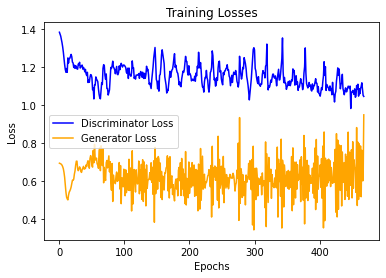

Epoch: 0 - D: (1.0460785627365112) | G: (0.9487873911857605)


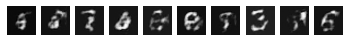

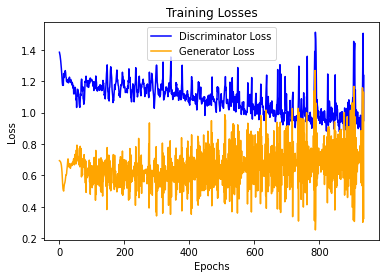

Epoch: 1 - D: (1.2370660305023193) | G: (0.3254491090774536)


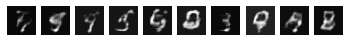

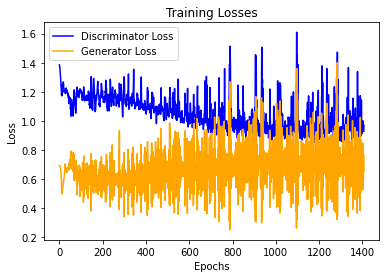

Epoch: 2 - D: (0.9297124743461609) | G: (0.6553556323051453)


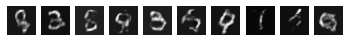

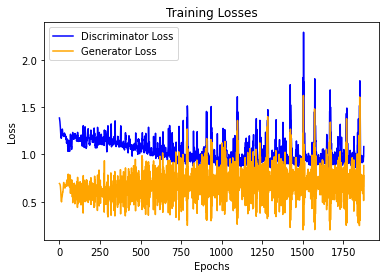

Epoch: 3 - D: (1.0833443403244019) | G: (0.882906436920166)


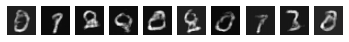

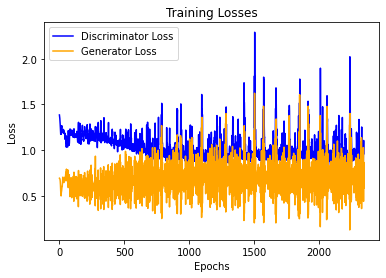

Epoch: 4 - D: (0.9604963064193726) | G: (0.5852655172348022)


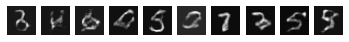

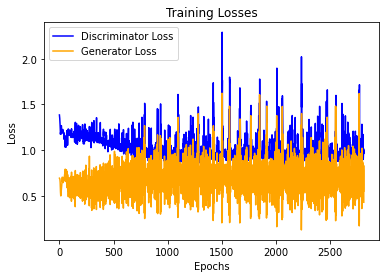

Epoch: 5 - D: (1.0093321800231934) | G: (0.42976492643356323)


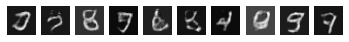

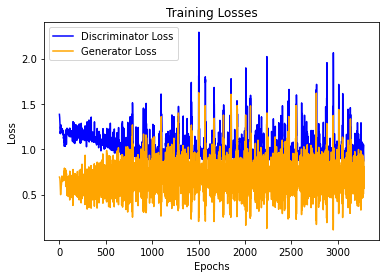

Epoch: 6 - D: (0.8741331100463867) | G: (0.6939839720726013)


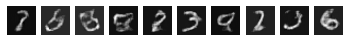

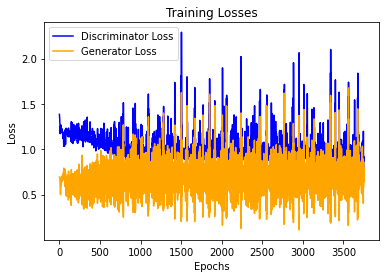

Epoch: 7 - D: (0.8104493618011475) | G: (0.8581523895263672)


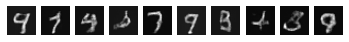

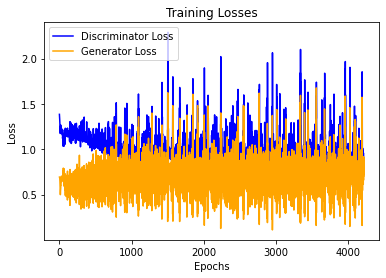

Epoch: 8 - D: (0.8985777497291565) | G: (0.6662065982818604)


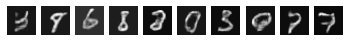

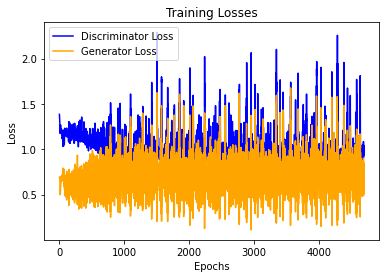

Epoch: 9 - D: (0.914635181427002) | G: (0.5982543230056763)


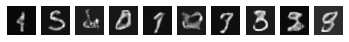

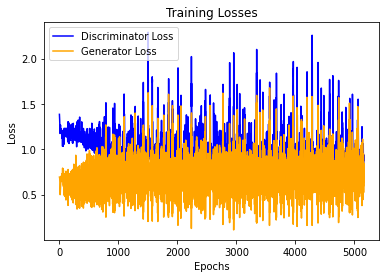

Epoch: 10 - D: (0.8473893404006958) | G: (0.6377484798431396)


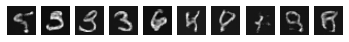

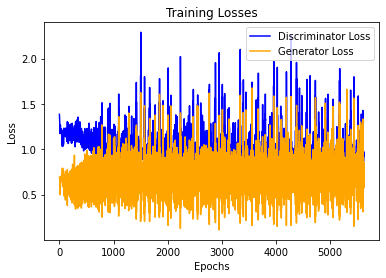

Epoch: 11 - D: (0.8738442063331604) | G: (0.6035842299461365)


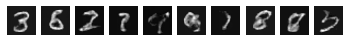

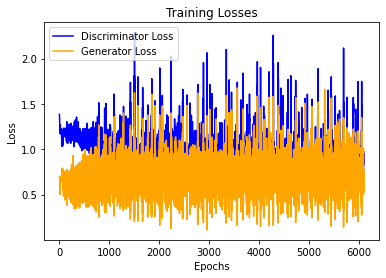

Epoch: 12 - D: (0.8663205504417419) | G: (0.5034698247909546)


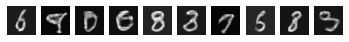

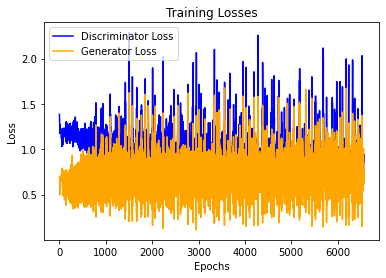

Epoch: 13 - D: (0.9328506588935852) | G: (0.7762640714645386)


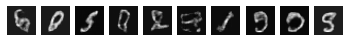

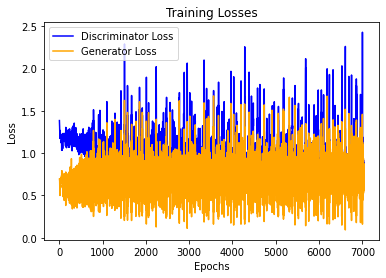

Epoch: 14 - D: (0.7617142200469971) | G: (0.725553035736084)


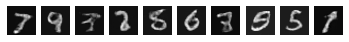

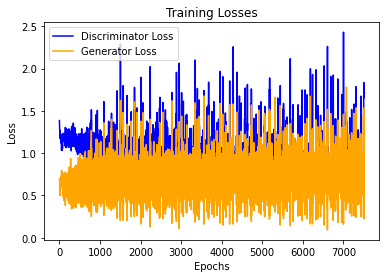

Epoch: 15 - D: (1.6541259288787842) | G: (1.0818860530853271)


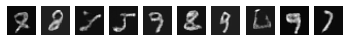

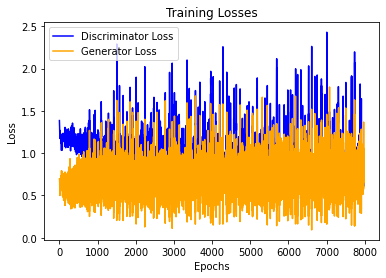

Epoch: 16 - D: (0.8139538764953613) | G: (0.8550375699996948)


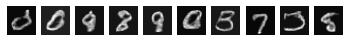

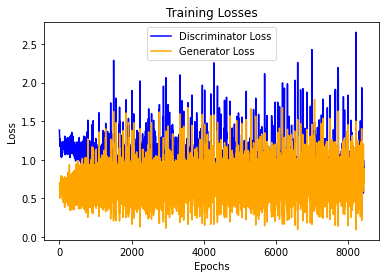

Epoch: 17 - D: (0.9058688879013062) | G: (0.8389565348625183)


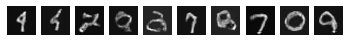

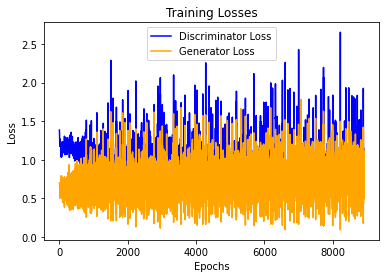

Epoch: 18 - D: (0.8283003568649292) | G: (1.004492163658142)


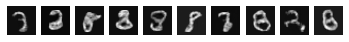

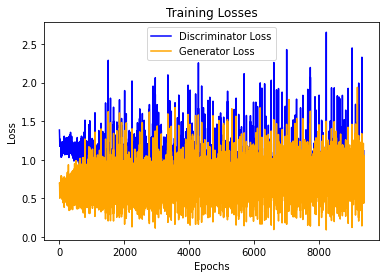

Epoch: 19 - D: (1.1155422925949097) | G: (0.8384067416191101)


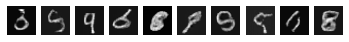

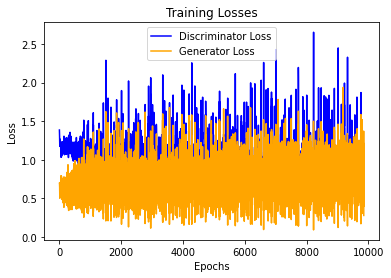

Epoch: 20 - D: (1.210099697113037) | G: (0.2761625647544861)


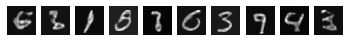

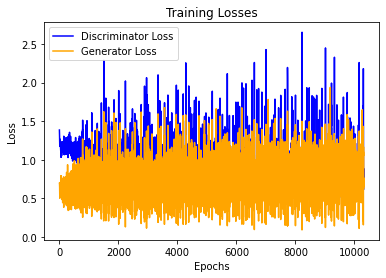

Epoch: 21 - D: (0.7803623676300049) | G: (0.6312127113342285)


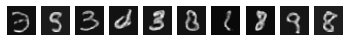

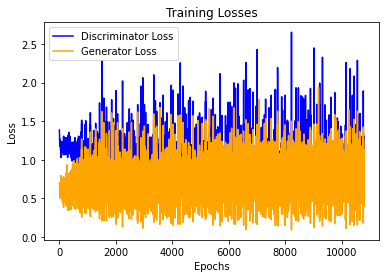

Epoch: 22 - D: (0.9566619396209717) | G: (0.9947876334190369)


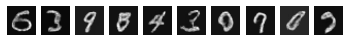

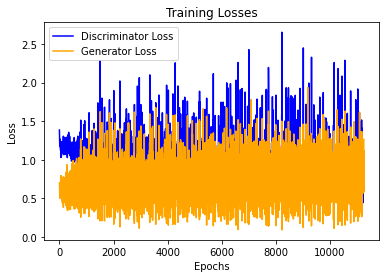

Epoch: 23 - D: (0.8769672513008118) | G: (1.264141321182251)


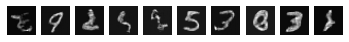

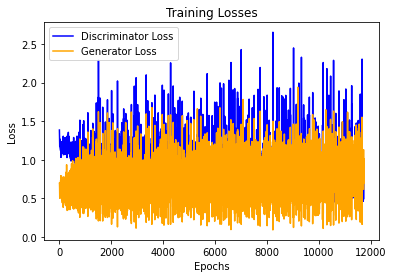

Epoch: 24 - D: (0.7360920310020447) | G: (0.6172423362731934)


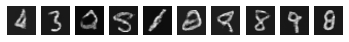

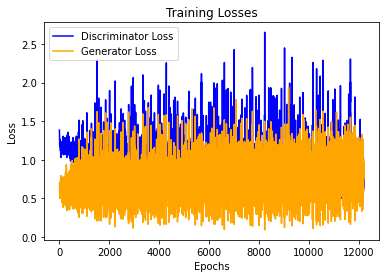

Epoch: 25 - D: (0.7521050572395325) | G: (0.6045997142791748)


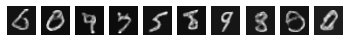

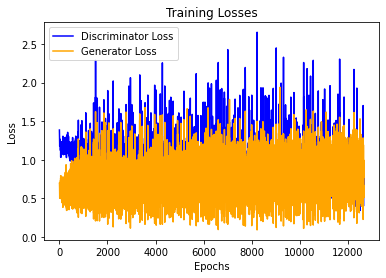

Epoch: 26 - D: (0.7147307991981506) | G: (0.6627973914146423)


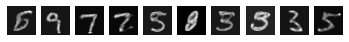

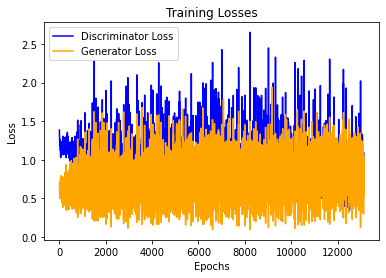

Epoch: 27 - D: (1.0894482135772705) | G: (0.29723677039146423)


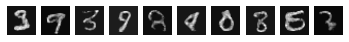

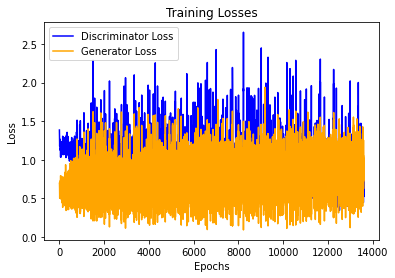

Epoch: 28 - D: (0.7496485710144043) | G: (0.6310811042785645)


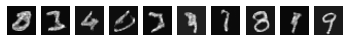

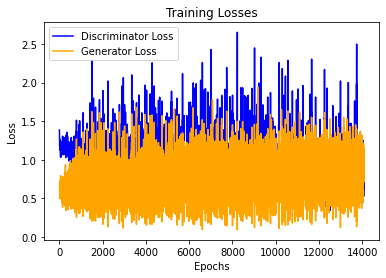

Epoch: 29 - D: (0.6791831254959106) | G: (0.7455892562866211)


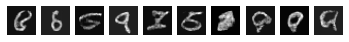

finished training


In [ ]:
d_loss, g_loss, generatedImages = train(z_i, maxEpochs)

After the training, we can print some results:

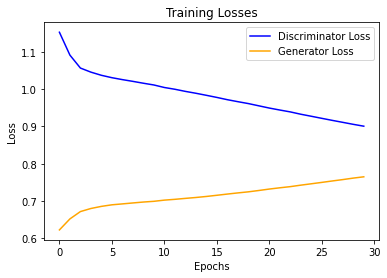

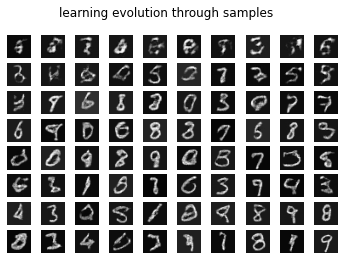

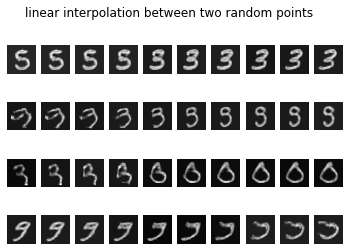

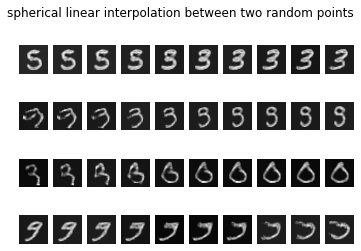

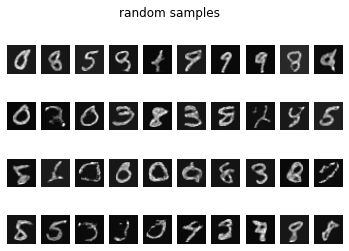

In [ ]:
# print losses
printLosses(d_loss, g_loss, save=True)

# print learning evolution
printImageMatrix(generatedImages, 'learning evolution through samples')

# print model trained samples
linearInterpolationSamples = []
sphericalInterpolationSamples = []
randomSamples = []

for _ in range(4):
    [p1,p2] = generateLatentPoints(2,z_i)
    linearInterpolationSamples.append(evaluateModel(G, z_i, mode='linear', p1=p1, p2=p2))
    sphericalInterpolationSamples.append(evaluateModel(G, z_i, mode='spherical', p1=p1, p2=p2))
    randomSamples.append(evaluateModel(G, z_i, mode='random'))

printImageMatrix(linearInterpolationSamples, 'linear interpolation between two random points')
printImageMatrix(sphericalInterpolationSamples, 'spherical linear interpolation between two random points')
printImageMatrix(randomSamples, 'random samples')

Save/load the trained models

In [ ]:
# define the file name
PATH = 'G_model_CNN_' + str(maxEpochs) + 'epochs' + '.pt'

# save model state dict
#torch.save(G.state_dict(), PATH)

# load trained model
#Gtrained = Generator(z_i, g_n)
#Gtrained.load_state_dict(torch.load(PATH))
#Gtrained.to(device)

# Recovering Latent Vector of a desired image

The goal here is to recover the latent vector that generates a desired image. This is done through a gradient based optimization of the latent vector. Given a random latent vector z, we compute the loss between the desired image and G(z), and update z based on the loss gradients.

See: Precise Recovery of Latent Vectors from Generative Adversarial Networks

This function finds an image in the real dataset with the desired label.

In [ ]:
def findImageinData(trainloader, label=0):
    for i,data in enumerate(trainloader,0):                
        images, labels = data[0], data[1]

        labels = labels.numpy()

        try:
            index = np.where(labels==label)[0][0]
            return images[index].to(device).reshape(1,1,28,28)
        except IndexError:
            continue


This function runs Adam optimization on the latent vector for a certain number of iterations.

In [162]:
def findLatentVector(G, z_i, image, maxEpochs=1000, patience=5):
    
    # choose a random starting point
    z = torch.randn(1, z_i, 1, 1, device=device, requires_grad=True)

    # define the optimization problem (method, loss)
    z_optimizer = optim.Adam([z], lr = 0.01)
    criterion = nn.MSELoss(reduction='sum')

    # run optimization
    z_optimizer.zero_grad()
    
    print('started latent space recovery')
    last_loss = 10000
    no_change = 0
    for epoch in range(maxEpochs + 1):
        loss = criterion(G(z), image)
        loss.backward()
        z_optimizer.step()

        if last_loss - loss.item() < 0:
            no_change += 1
        else:
            no_change = 0
        
        if no_change >= patience:
            break
        
        last_loss = loss.item()
        #print('loss:', last_loss)
        #print('no change:', no_change)
    
    print('total number of epochs:', epoch)
    print('final loss:', last_loss)
    print('finished latent space recovery')
    return z.detach()

This function generates interpolation between two desired images, given their labels.

In [172]:
def visualizeTransition(G, z_i, label1, label2):
    # find images in the dataset with the desired label
    target_image1 = findImageinData(trainloader, label=label1)
    target_image2 = findImageinData(trainloader, label=label2)
    print('Images taken from the Dataset:')
    printImages([target_image1, target_image2])

    # find the latent space vectors that generate replicas of those images
    print('\nlabel:', str(label1))
    z1 = findLatentVector(G, z_i, target_image1, maxEpochs=5000)
    print('\nlabel:', str(label2))
    z2 = findLatentVector(G, z_i, target_image2, maxEpochs=5000)

    # interpolate between the two points and print samples
    print('\nlinear interpolation of samples')
    interpolatedImages = evaluateModel(G, z_i, mode='linear', p1=z1, p2=z2)
    printImages(interpolatedImages)
    
    print('\nspherical linear interpolation of samples')
    interpolatedImages = evaluateModel(G, z_i, mode='spherical', p1=z1, p2=z2)
    printImages(interpolatedImages)

Images taken from the Dataset:


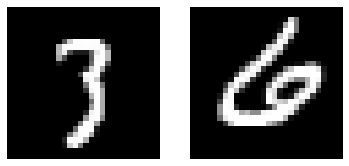


label: 3
started latent space recovery
total number of epochs: 208
final loss: 10.934307098388672
finished latent space recovery

label: 6
started latent space recovery
total number of epochs: 229
final loss: 35.98625946044922
finished latent space recovery

linear interpolation of samples


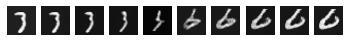


spherical linear interpolation of samples


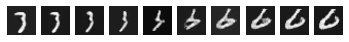

In [181]:
visualizeTransition(G,z_i,3,6)

In [163]:
def genSimilarImage(G, z_i, target_image):
    z = findLatentVector(G, z_i, target_image)
    # generate sample images
    G.eval()
    with torch.no_grad():
        sample_image = G(z)
    
    return sample_image
    #printImages([target_image, sampleImage])

[0 5 2 0 8]
started latent space recovery
total number of epochs: 555
final loss: 24.630199432373047
finished latent space recovery
started latent space recovery
total number of epochs: 81
final loss: 26.19577407836914
finished latent space recovery
started latent space recovery
total number of epochs: 200
final loss: 34.95990753173828
finished latent space recovery
started latent space recovery
total number of epochs: 113
final loss: 39.00010299682617
finished latent space recovery
started latent space recovery
total number of epochs: 21
final loss: 53.43141174316406
finished latent space recovery


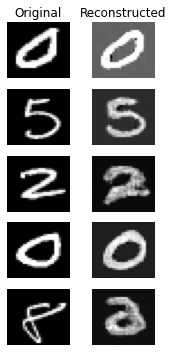

In [171]:
labels = np.random.randint(0,9,(1,5)).flatten()
print(labels)
fig, ax = plt.subplots(5,2, figsize=(2.5,5))
fig = plt.figure(1)
for idx, label in enumerate(labels):
    target_image = findImageinData(trainloader, label)
    sample_image = genSimilarImage(G, z_i, target_image)
    ax[idx,0].imshow(target_image.view(28,28).cpu().numpy(), cmap='gray')
    ax[idx,1].imshow(sample_image.view(28,28).cpu().numpy(), cmap='gray')
    ax[idx,0].set_axis_off()
    ax[idx,0].set_aspect("auto")
    ax[idx,1].set_axis_off()
    ax[idx,1].set_aspect("auto")

ax[0,0].set_title('Original')
ax[0,1].set_title('Reconstructed')
plt.tight_layout()
plt.savefig('image:latent vector recovery.png')